In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv')
df.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [2]:
with_None = np.array([1, None, 2])
with_NaN = np.array([1, np.nan, 2])
print(f'with_None dtype: {with_None.dtype}\n' + 
      f'with_NaN dtype: {with_NaN.dtype}')

with_None dtype: object
with_NaN dtype: float64


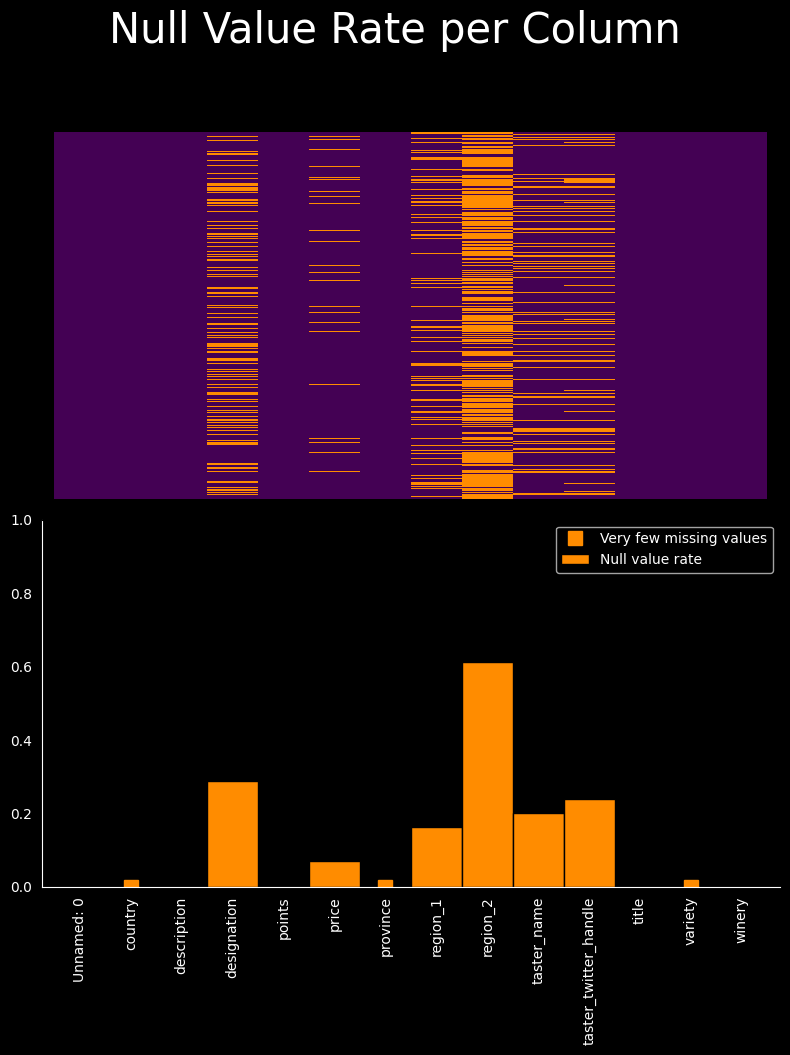

In [3]:
# NOTE: somehow, the heatmap of my dataset doesn't show the null value sin the columns 
# 'country', 'province' and 'variety'. Please help me to fix this.
def nullscan(df_check, save=False):
    '''
    df: a dataframe on which we want to perofrm the nullscan
    save: determines, whether you want to save the .png of the plot or not
    
    plots the rate of null values per column in a dataframe using 
    a seaborn heatmap and a barplot.
    '''    
    # a df with the same size of the original dataframe, containing True in cells containing NUll values.
    # and False in all the other cells.
    df_nulls = df_check.isna()
    # a series containing the sum of all values within a column having the column names as indices.
    # True is interpreted as 1 and False is interpreted as 0 
    nulls_per_col = df_nulls.sum(axis=0)
    # the rate makes it way more interpretable:
    nulls_per_col /= len(df_check.index)

    with plt.style.context('dark_background'):
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 10))
    
        # ax1 is losely based on: https://www.kaggle.com/ipshitagh/wine-dataset-data-cleaning
        # NOTE: I could have used the cmap viridis or anything else instead, 
        # but I want to make clear that you can use any customized cmap as well.
        vir = matplotlib.colormaps.get_cmap('viridis')
        colormap = matplotlib.colors.ListedColormap([vir(0), 'darkorange'])
        sns.heatmap(df_check.isnull(), cmap=colormap, cbar=False, yticklabels=False, ax=ax1)
    
        nulls_per_col.plot(kind='bar', color='darkorange', x=nulls_per_col.values, 
                           y=nulls_per_col.index, ax=ax2, width=1, linewidth=1, 
                           edgecolor='black', align='edge', label='Null value rate')
        
        ax2.set_ylim((0,1))
        # centered labels
        labels=df_check.columns
        ticks = np.arange(0.5, len(labels))
        ax2.xaxis.set(ticks=ticks, ticklabels=labels)
    
        # hide spines:
        # NOTE: I could have used ax2.set_frameon(False), 
        # but I wanted the bottom and the left spine to stay white.
        ax2.spines['top'].set_color('black')
        ax2.spines['right'].set_color('black')
        
        
        
        # workaround to visualize very small amounts of null values per col
        na_ticks = ticks[(nulls_per_col > 0) & (nulls_per_col < 0.05)]
        if (len(na_ticks) > 0):
            ax2.plot(na_ticks, [0,]*len(na_ticks), 's', c='darkorange', markersize=10, 
                     label='Very few missing values')
    
        fig.suptitle('Null Value Rate per Column', fontsize=30, y=1.05)
        ax2.legend()
        fig.tight_layout() 
        if(save):
            plt.savefig('nullscan.png')
        plt.show()
nullscan(df)

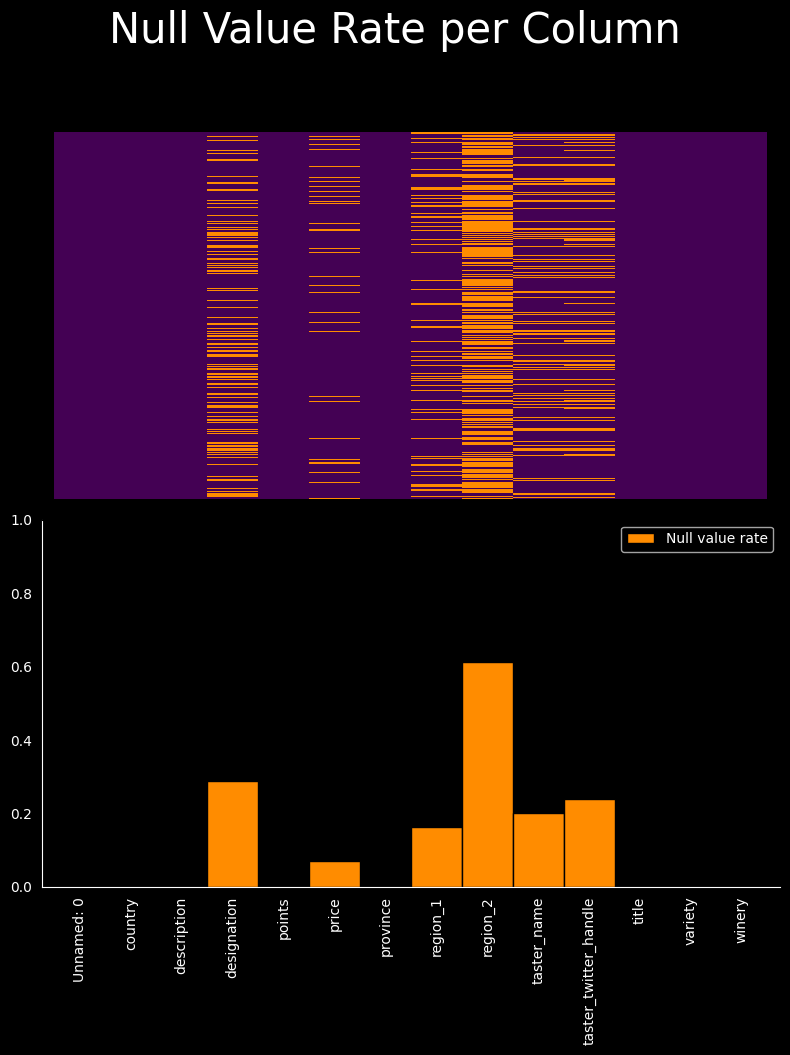

In [4]:
# drop all rows with Null values in 'country', 'province' OR 'variety':
df = df.dropna(subset=['country', 'province', 'variety'])

# one could even drop all rows containing 'too many' Null values:
# nrows_before = len(df.index)
# na_allowed = int(len(df.columns)/3)
# thresh = int(len(df.columns)) - na_allowed
# df = df.dropna(axis=0, thresh=thresh)
# nrows_afterwards = len(df.index)
nullscan(df, save=True)

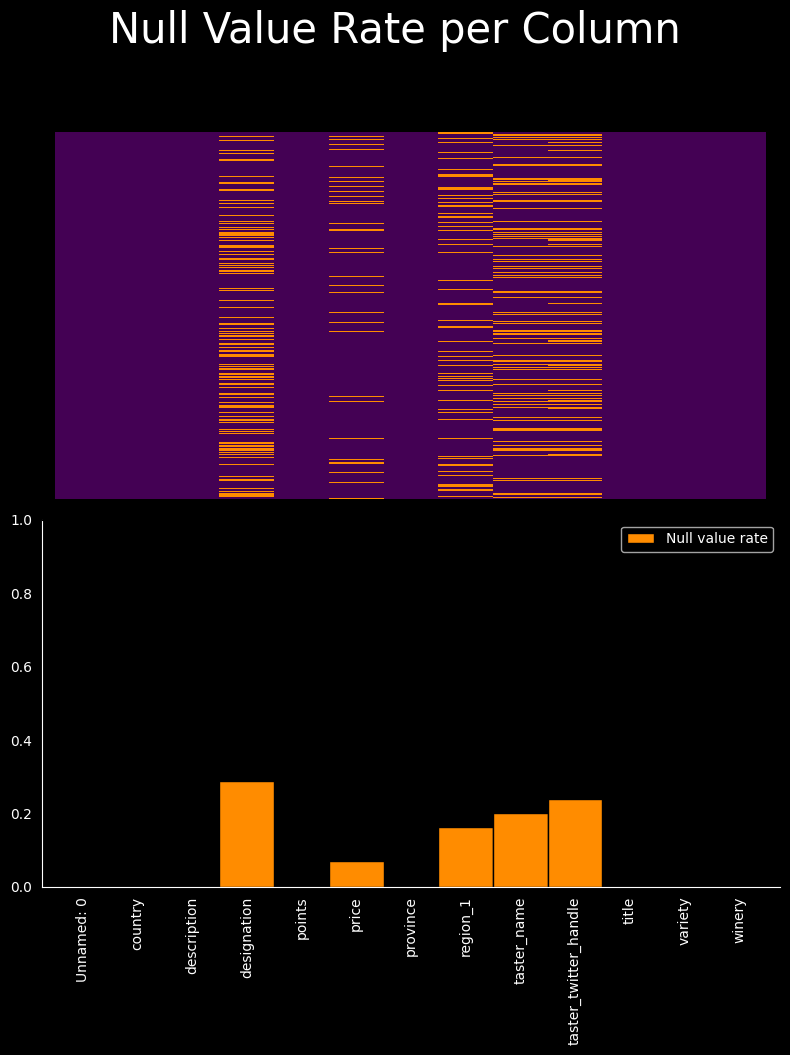

In [5]:
df = df.drop('region_2', axis=1)

nullscan(df)

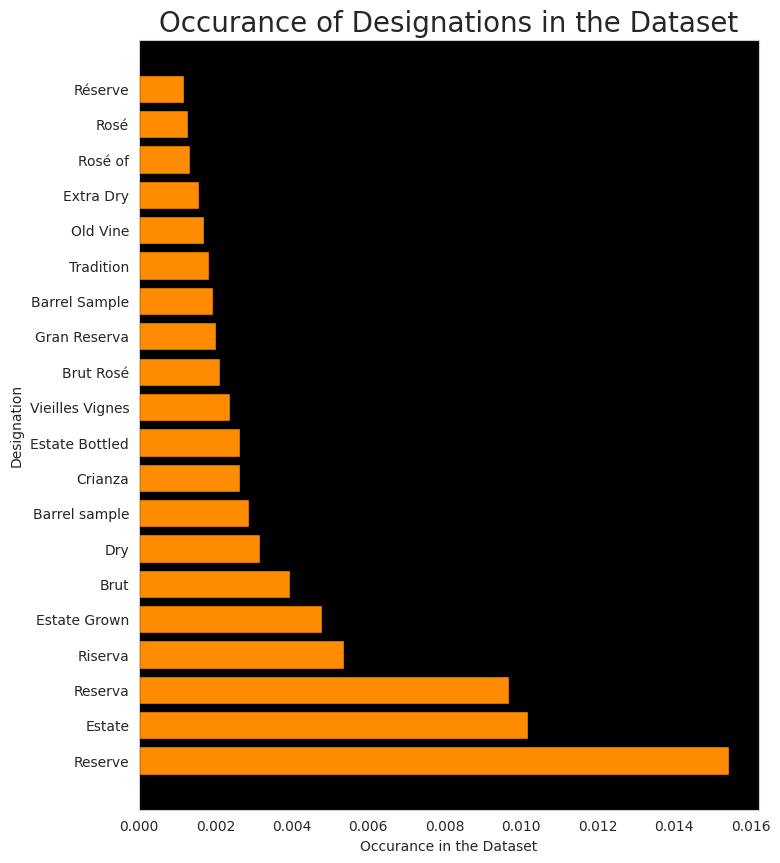

In [6]:
designation = df['designation'].value_counts().head(20) / len(df.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), sharey=True)
ax.barh(y=designation.index, width=designation.values, color='darkorange', edgecolor='black')
ax.set_title('Occurance of Designations in the Dataset', fontsize=20)
ax.set_xlabel('Occurance in the Dataset')
ax.set_ylabel('Designation')
ax.set_facecolor('black')

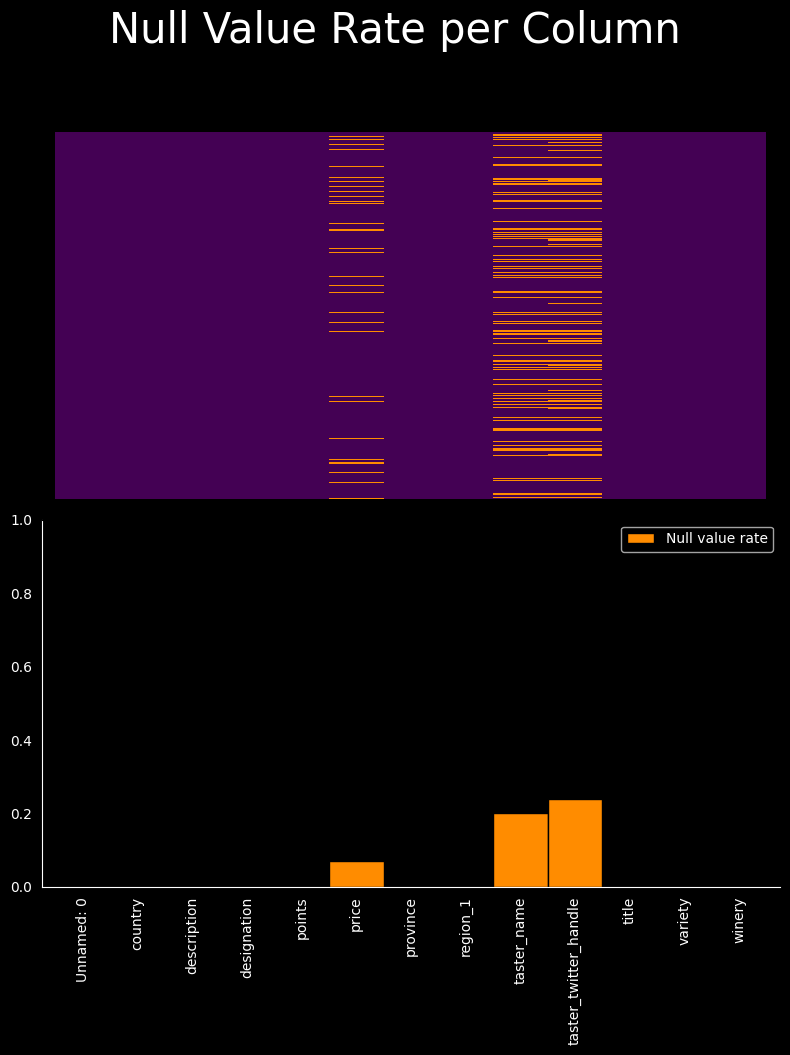

In [7]:
df[['designation', 'region_1']] = df[['designation', 'region_1']].fillna('Unknown')
nullscan(df)

In [8]:
only_name = df.loc[df['taster_twitter_handle'].isnull() & df['taster_name'].notna(), 
                   ['taster_name', 'taster_twitter_handle']]
num_only_name = len(only_name.index)

only_twitter = df.loc[df['taster_name'].isnull() & df['taster_twitter_handle'].notna(), 
                      ['taster_name', 'taster_twitter_handle']]
num_only_twitter = len(only_twitter.index)

print(f'rows containing a name but no twitter handle: {num_only_name}'
      + f'\nrows containing a twitter handle but no taster name: {num_only_twitter}')

rows containing a name but no twitter handle: 4969
rows containing a twitter handle but no taster name: 0


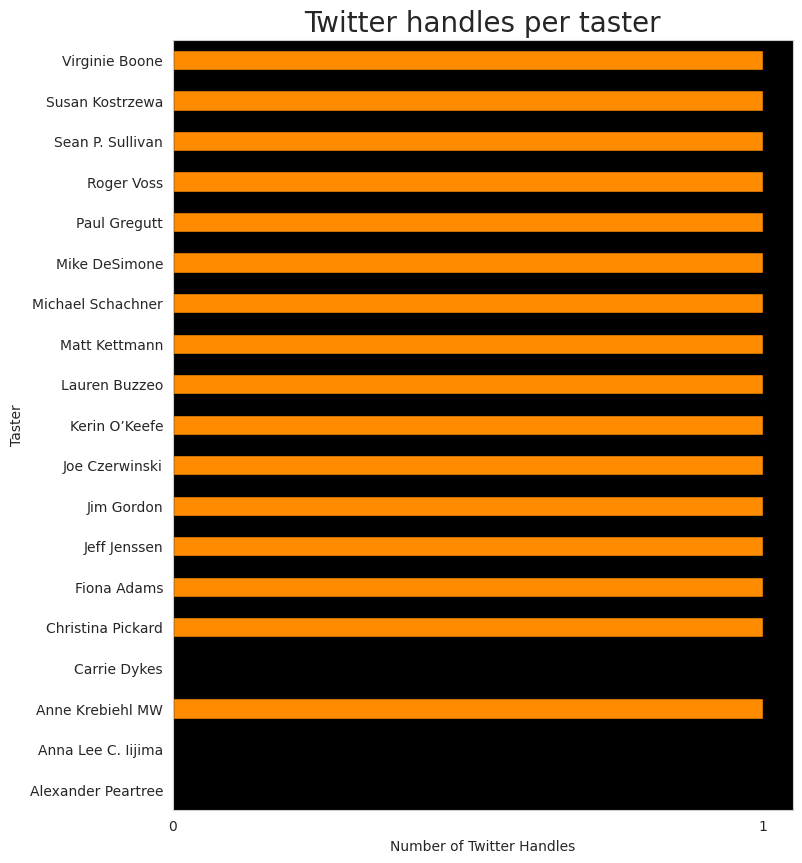

In [9]:
twitter_per_name = df.groupby('taster_name')['taster_twitter_handle'].nunique()
labels = twitter_per_name.index


fig, ax = plt.subplots(figsize=(8,10))
twitter_per_name.plot(kind='barh', ax=ax, color='darkorange', edgecolor='black')
ax.set_xticks([0,1])
ax.set_xlabel('Number of Twitter Handles')
ax.set_ylabel('Taster')
ax.set_title('Twitter handles per taster', fontsize=20)
ax.set_facecolor('black')

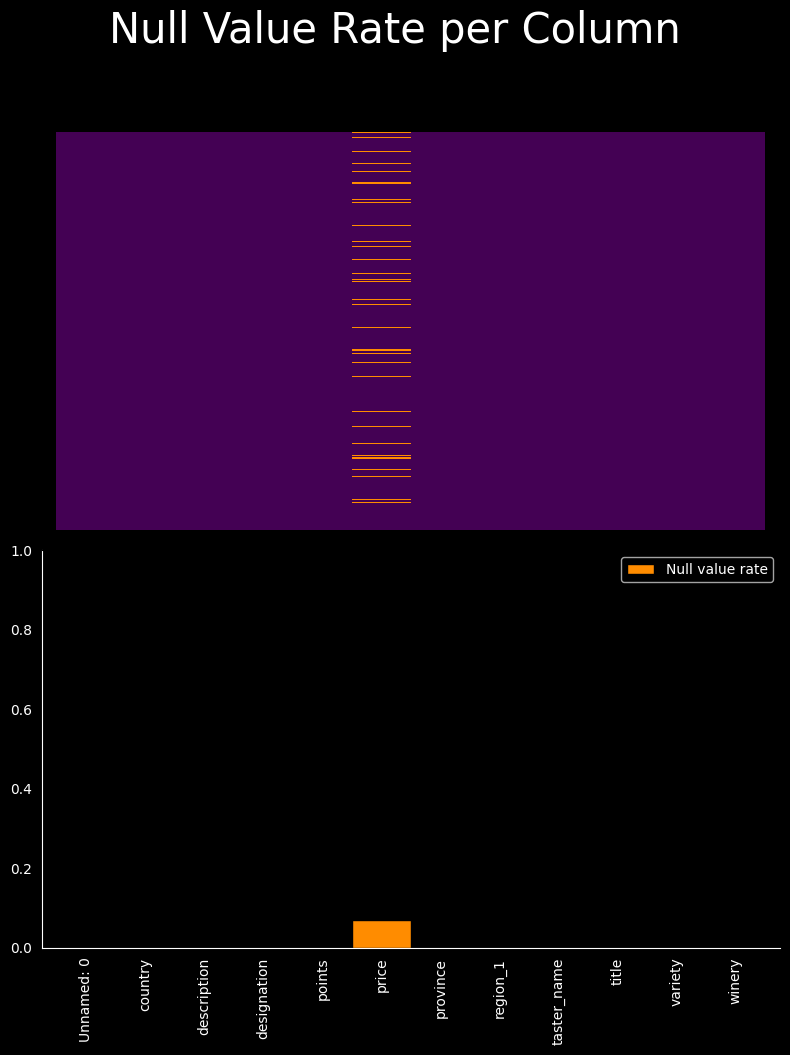

In [10]:
df = df.drop('taster_twitter_handle', axis=1)
df['taster_name'] = df['taster_name'].fillna('Unknown')
nullscan(df)

In [11]:
df_cleanup = df.loc[:, ['price', 'points', 'country', 'taster_name']]
encoded = pd.get_dummies(df_cleanup[['country', 'taster_name']], prefix=['country', 'taster_name'])
df_cleanup = pd.concat([df_cleanup.drop(['country', 'taster_name'], axis=1), encoded], axis=1)

# training data
df_cleanup_known = df_cleanup.loc[df_cleanup['price'].notnull(), :]
Train_X_known = df_cleanup_known.drop('price', axis=1)
Train_y_known = df_cleanup_known['price']

# prediction data
df_cleanup_unknown = df_cleanup.loc[df_cleanup['price'].isnull(), :]
X_unknown = df_cleanup_unknown.drop('price', axis=1)

In [12]:
from sklearn.model_selection import GridSearchCV
knn_cleanup = KNeighborsRegressor()

# simple finetuning:
params = {'n_neighbors':[1,5,9]}
gs = GridSearchCV(knn_cleanup, params)
gs.fit(Train_X_known, Train_y_known)
knn_cleanup = gs.best_estimator_

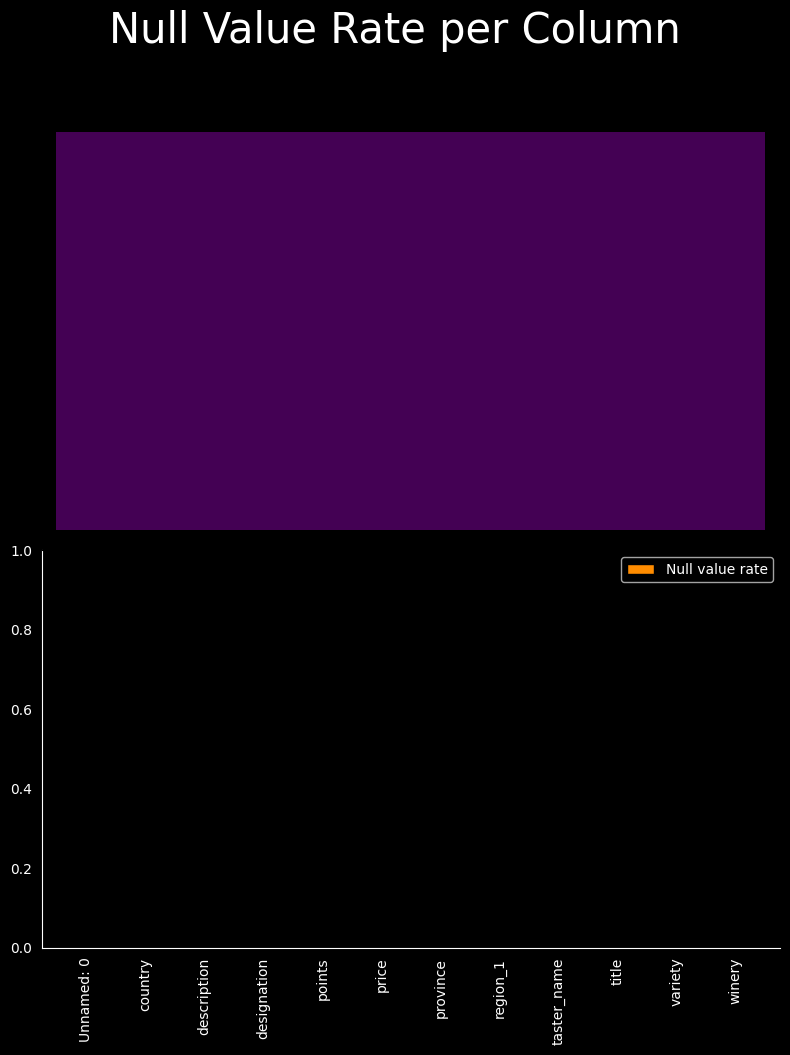

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
0,1870,Portugal,"Pitch-black wine, very dense. It is spicy with...",Picos de Couto Grande Escolha,93,50.222222,Dão,Unknown,Roger Voss,Castro Pena Alba 2007 Picos de Couto Grande Es...,Portuguese Red,Castro Pena Alba
1,15517,US,Fresh smoke from your grandpa's pipe swirls wi...,1772,93,60.000000,California,Edna Valley,Matt Kettmann,Tolosa 2012 1772 Pinot Noir (Edna Valley),Pinot Noir,Tolosa
2,44720,France,While this wine certainly has a tannic backgro...,Premier Cru,88,80.000000,Burgundy,Pommard,Roger Voss,Manuel Olivier 2011 Premier Cru (Pommard),Pinot Noir,Manuel Olivier
3,59100,Portugal,This smooth and rich selection is wood aged an...,Mux Tinto,92,30.000000,Douro,Unknown,Roger Voss,Muxagat 2010 Mux Tinto Red (Douro),Portuguese Red,Muxagat
4,16854,US,From the old vineyard in back of Don Hartford'...,Hartford Vineyard,93,34.000000,California,Russian River Valley,Unknown,Hartford 1999 Hartford Vineyard Zinfandel (Rus...,Zinfandel,Hartford


In [13]:
df_known = df.loc[df['price'].notnull(),:]
df_predicted = df.loc[df['price'].isnull(),:]

# to evade SettingWithCopyWarning
df_predicted = df_predicted.drop('price', axis=1)
df_predicted['price'] = knn_cleanup.predict(X_unknown)
df = pd.concat([df_known, df_predicted], axis=0, ignore_index=True)

# shuflle the dataset along rows
df = df.sample(frac=1).reset_index(drop=True)



nullscan(df)
df.head()

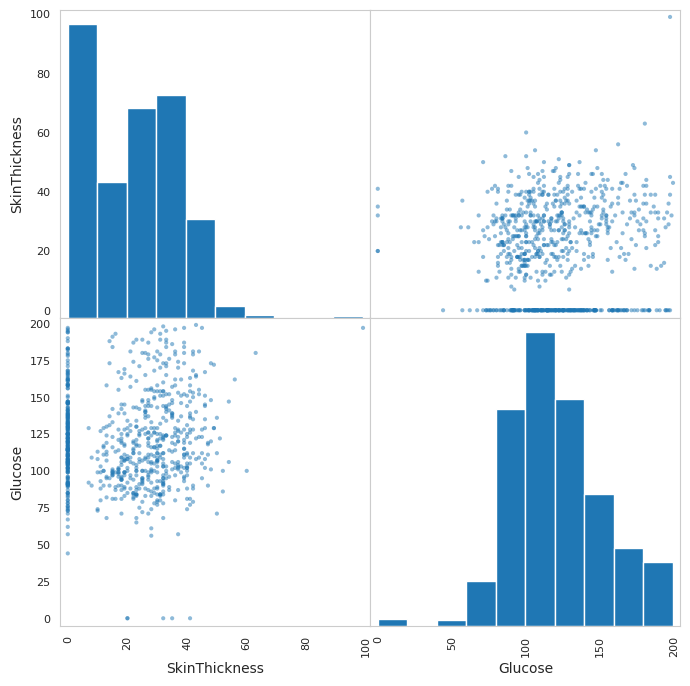

In [14]:
from pandas.plotting import scatter_matrix
data_diabetes = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')[['SkinThickness', 'Glucose']]
scatter_matrix(data_diabetes, figsize=(8,8));

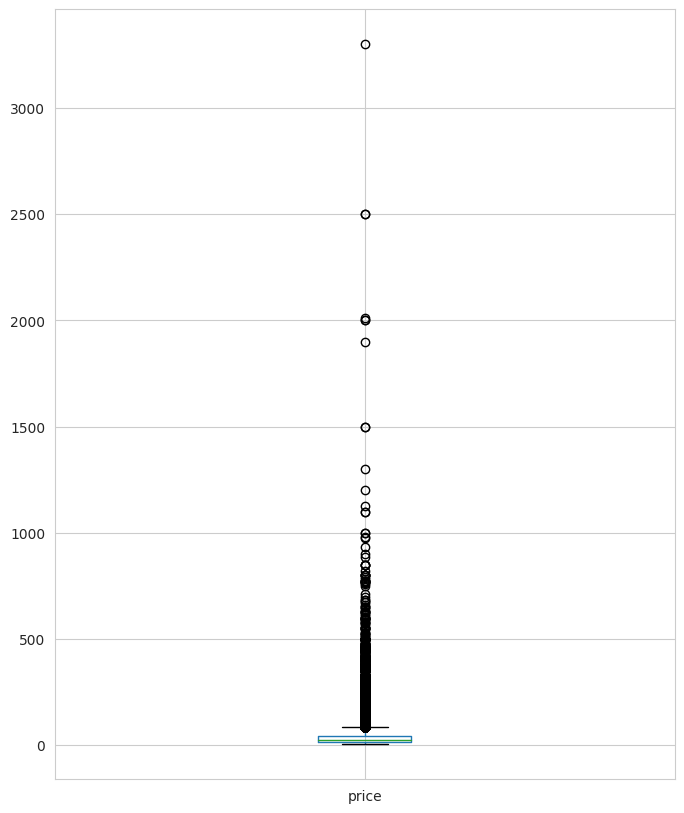

In [15]:
#best way of identifying outlier is the use of z score and visualizing the data using boxplot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 10))
df.boxplot(column='price', ax=ax1)
ax.set_title('Outliers in Price?');

In [16]:
from scipy import stats

# display all rows having outliers in 'price'
data = pd.DataFrame(df['price'])
data_zscore = data.apply(stats.zscore, axis=0)
mask_outliers = ((data_zscore>6).any(axis=1)).values + ((data_zscore<-6).any(axis=1)).values
data.loc[mask_outliers,:]

,price
219,299.000000
230,426.000000
245,775.000000
456,430.000000
475,400.000000
...,...
125724,379.222222
125945,300.000000
126171,440.000000
129011,474.000000


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


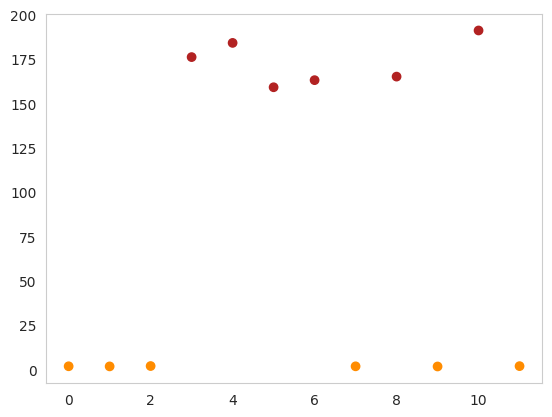

In [17]:
from sklearn.cluster import KMeans
height = np.array([1.74, 1.67, 1.87, 176, 184, 159, 163, 1.71, 165, 1.62, 191, 1.82])
np.size(height)

# use kmeans; try different number of clusters, if needed
cluster_kmeans = KMeans(n_clusters=2)
cluster_kmeans.fit(height.reshape((-1,1)))
# plot
colors = np.array(['darkorange', 'firebrick'])
plt.scatter(x=range(np.size(height)), y=height, c=colors[cluster_kmeans.labels_])
plt.show()

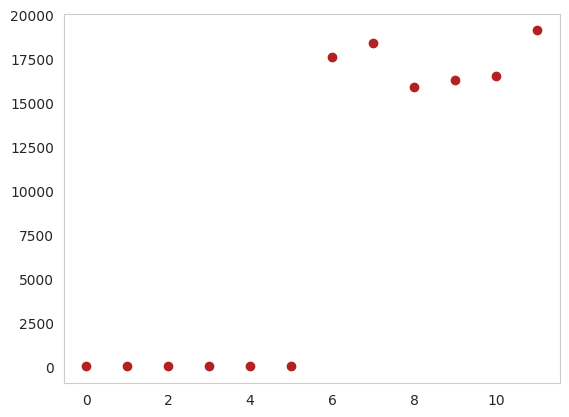

In [18]:
# separate the clusters
height_meter = height[cluster_kmeans.labels_ == 1]
height_cm = height[cluster_kmeans.labels_ == 0]
# bring them on a mutually equal scale
height_meter = height_meter * 100
# plot
height_transformed = np.append(height_cm, height_meter)
plt.scatter(x=range(np.size(height)), y=height_transformed, c='firebrick')
plt.show()

In [19]:
# our data doesn't contain any duplicates
df.duplicated().sum()

0

In [20]:
#Sample data to simulate having a duplicate data.
dupli_values = np.array([[1,2],
                        [1,2],
                        [3,4],
                        [5,6],
                        [3,4]])

dupli_data = pd.DataFrame(data = dupli_values, columns=['a', 'b'])
dupli_data

,a,b
0,1,2
1,1,2
2,3,4
3,5,6
4,3,4


In [21]:
def remove_duplicates(data):
    dupli_con = pd.Series(range(len(data)))[data.duplicated() == False]
    return data.loc[dupli_con,:]
    
remove_duplicates(dupli_data)

,a,b
0,1,2
2,3,4
3,5,6
